In [1]:
# Load Qiskit
from qiskit_ibm_runtime import QiskitRuntimeService, Batch
from dotenv import load_dotenv, find_dotenv
import os

load_dotenv()
API_TOKEN = os.getenv("API_TOKEN")
API_INSTANCE = os.getenv("API_INSTANCE", None)
service = QiskitRuntimeService(channel="ibm_cloud", token=API_TOKEN, instance=API_INSTANCE)
backend = service.backend(name="ibm_rensselaer")


from IPython.display import display

import numpy as np
import networkx as nx
import qiskit
import sympy
from qiskit import transpile, QuantumCircuit

1834


None

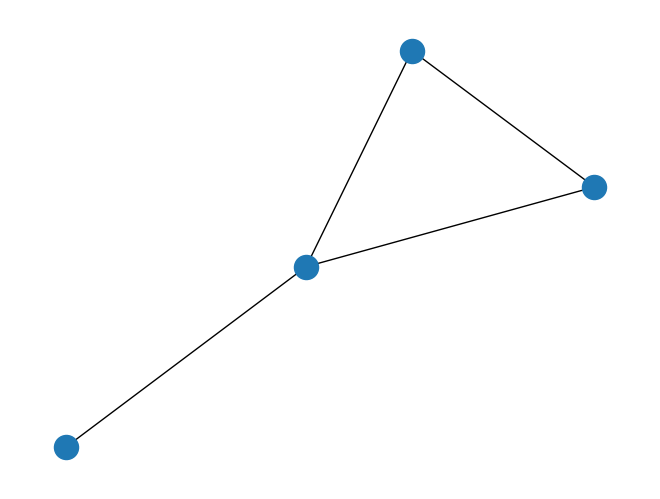

In [2]:
from benchmarklib.databases import CliqueDatabase


db = CliqueDatabase().shared()
clique_problem = db.get(1834)
print(clique_problem.instance_id)

G = nx.from_numpy_array(clique_problem.as_adjacency_matrix())
display(nx.draw(G))

def clique_oracle(vertices: BitVec(4, '0000')) -> BitVec(1):
    """Counts cliques of size 2 in a graph specified by the edge list."""
    s = BitVec(1, 1)
    s = s & ~(vertices[1] & vertices[2])
    s = s & ~(vertices[1] & vertices[3])
    s_0_0 = BitVec(1, 1)
    s_0_1 = BitVec(1, 0)
    s_0_2 = BitVec(1, 0)
    s_1_0 = BitVec(1, 1)
    s_1_1 = s_0_1 | vertices[0] & s_0_0
    s_1_2 = BitVec(1, 0)
    s_2_0 = BitVec(1, 1)
    s_2_1 = s_1_1 | vertices[1] & s_1_0
    s_2_2 = s_1_2 | vertices[1] & s_1_1
    s_3_0 = BitVec(1, 1)
    s_3_1 = s_2_1 | vertices[2] & s_2_0
    s_3_2 = s_2_2 | vertices[2] & s_2_1
    s_4_0 = BitVec(1, 1)
    s_4_1 = s_3_1 | vertices[3] & s_3_0
    s_4_2 = s_3_2 | vertices[3] & s_3_1
    at_least_k = s_4_2
    return s & at_least_k


None

{}
{'22': {0: {'negated': True}}}
{'8': {0: {'negated': False}}, '21': {0: {'negated': False}}}
{'9': {0: {'negated': False}}, '20': {0: {'negated': False}}}
{'10': {0: {'negated': False}}, '19': {0: {'negated': False}}}
{'16': {0: {'negated': False}}, '18': {0: {'negated': False}}}
{'15': {0: {'negated': False}}, '17': {0: {'negated': False}}}
{'15': {0: {'negated': False}}, '16': {0: {'negated': False}}}
{'12': {0: {'negated': True}}, '14': {0: {'negated': True}}}
{'9': {0: {'negated': False}}, '10': {0: {'negated': True}}}
{'10': {0: {'negated': False}}, '11': {0: {'negated': False}}}
{'10': {0: {'negated': False}}, '13': {0: {'negated': False}}}
{'8': {0: {'negated': False}}, '9': {0: {'negated': False}}}
{'4': {0: {'negated': False}}, '9': {0: {'negated': False}}}
{'6': {0: {'negated': False}}, '9': {0: {'negated': False}}}
{'7': {0: {'negated': False}}, '8': {0: {'negated': False}}}
{'3': {0: {'negated': False}}, '6': {0: {'negated': False}}}
{'1': {0: {'negated': False}}, '6': {

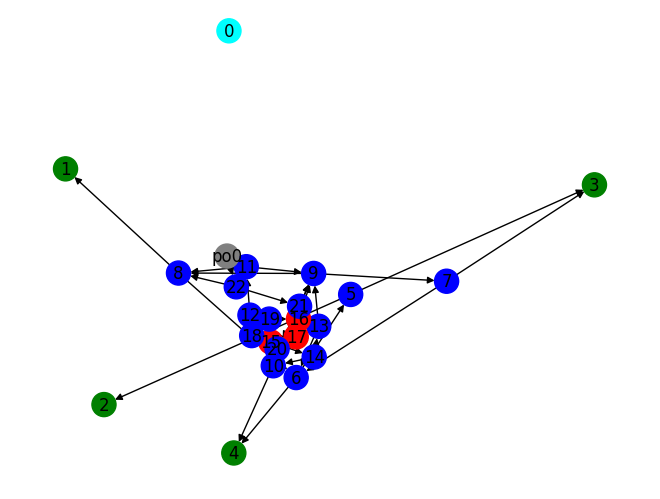

In [ ]:
from benchmarklib.pipeline import PipelineCompiler, PipelineStep
from benchmarklib.pipeline.synthesis import XAGSynthesizer, Synthesizer
from benchmarklib import setup_logging

class PrintTransformedSource(PipelineStep):

    @property
    def name(self) -> str:
        return self.__class__.__name__

    def transform(self, synthesizer: Synthesizer, circuit: QuantumCircuit, **kwargs) -> QuantumCircuit:
        if synthesizer.compilation_artifacts:
            print(synthesizer.compilation_artifacts['source'])

        return circuit

class CreateNXGraph(PipelineStep):

    @property
    def name(self) -> str:
        return self.__class__.__name__

    def transform(self, synthesizer: Synthesizer, circuit: QuantumCircuit, **kwargs) -> QuantumCircuit:
        import pygraphviz

        if isinstance(synthesizer, XAGSynthesizer):
            dot_str = synthesizer.compilation_artifacts['xag_graphviz']
            A = pygraphviz.AGraph()
            A.from_string(dot_str)
            G = nx.drawing.nx_agraph.from_agraph(A)

            for node, data in G.nodes.data():
                try:
                    node_label = int(data['label'])
                    if node_label != 0:
                        data['label'] = f"input{node_label}"
                        data['color'] = 'green'
                    else:
                        data['color'] = 'cyan'
                except:
                    clr_map = {"XOR": "blue", "AND": "red"}
                    if node != "po0":
                        data['color'] = clr_map[data['label']]
                    pass

                del data['fillcolor']
                del data['shape']
                del data['style']
                #print((node, data))
                

            for u, v, data in G.edges.data():
                data['negated'] = data['style'] == "dashed"
                del data['style']
                #print(data)
            
            color_map = []
            for node in G.nodes:
                color_map.append(G.nodes[node].get('color', 'gray')) # Use 'gray' as default

            synthesizer.compilation_artifacts['color_map'] = color_map
            #display(nx.draw(G, node_color=color_map, with_labels=True))
            synthesizer.compilation_artifacts['xag'] = G
        else:
            print("WARNING: Not XAG Synthesizer, cannot perform graph operations")

        return circuit
    

class BoolFunctionFromNXGraph(PipelineStep):

    @property
    def name(self) -> str:
        return self.__class__.__name__

    def transform(self, synthesizer: Synthesizer, circuit: QuantumCircuit, **kwargs) -> QuantumCircuit:
        if isinstance(synthesizer, XAGSynthesizer):
           G = synthesizer.compilation_artifacts['xag']

           if not isinstance(G, nx.MultiDiGraph):
               raise ValueError("Expected nx XAG")
           
           G_rev = G.to_directed().reverse()
           color_map = synthesizer.compilation_artifacts['color_map']
           display(nx.draw(G_rev, node_color=color_map, with_labels=True))
           
           nodes = list(nx.topological_sort(G_rev))
           for node in nodes:
               print(G_rev[node])

           print("\nSTARTING EXPRESSION BUILDER")
           expr = self.build_expression(G_rev, nodes[2])

           # check final edge to see if we need to negate our expr
           # first edge is always the one we want, nx was giving me issues so we put it in a loop
           for u, v, data in G.in_edges("po0", data=True):
               if data['negated']:
                   expr = sympy.Not(expr)
                   print(expr)
               synthesizer.compilation_artifacts['reduced_expr'] = expr
               return circuit
        else:
            print("WARNING: Not XAG Synthesizer, cannot perform graph operations")
            return circuit

    def build_expression(self, graph: nx.MultiDiGraph, node, memo=None):
        
        """
        Recursively builds a sympy boolean expression from a graph,
        starting from the output node.

        Args:
            graph (nx.MultiDiGraph): The graph to traverse.
            node_id: The ID of the current node to process.
            memo (dict): A dictionary to store results and avoid recomputing.

        Returns:
            A sympy boolean expression for the subtree
            rooted at the given node.
        """
        if memo is None:
            memo = {}
        
        # Check if we have already computed this node's expression
        if node in memo:
            return memo[node]

        #print(graph[node], graph.nodes[node])
        node_label = graph.nodes[node]['label']

        # Handle input nodes which don't have an operation
        if "input" in node_label:
            # There should only be incoming edges to the reversed graph input nodes.
            for u, v, key, data in graph.in_edges(node, keys=True, data=True):
                is_negated = data.get('negated', False)
                input_expr = sympy.Symbol(f"x{node_label[5:]}") # name variable in sympy xNUM 
                
                if is_negated:
                    result = sympy.Not(input_expr)
                else:
                    result = input_expr
                memo[node] = result
                return result

        # Recursive step: The node is a logic gate.
        gate_type = node_label.upper()
        sub_expressions = []

        # Iterate through the incoming edges to get the parent nodes and edge data.
        for u, v, key, data in graph.out_edges(node, keys=True, data=True):
            is_negated = data.get('negated', False)
            
            # Recursively build the expression for the parent node.
            parent_expression = self.build_expression(graph, v, memo)
            
            # Apply negation if the edge is dashed.
            if is_negated:
                sub_expressions.append(sympy.Not(parent_expression))
            else:
                sub_expressions.append(parent_expression)
        
        # Join the sub-expressions with the appropriate operator.
        if gate_type == 'XOR':
            result = sympy.Xor(*sub_expressions)
        elif gate_type == 'AND':
            result = sympy.And(*sub_expressions)
        else:
            # Fallback for other gate types
            result = f"({gate_type} {str(sub_expressions)})" 
            
        # Store the result in the memoization dictionary before returning.
        memo[node] = result
    
        return result


compiler = PipelineCompiler(synthesizer=XAGSynthesizer(), 
                            steps = [
                                PrintTransformedSource(),
                                CreateNXGraph(),
                                BoolFunctionFromNXGraph()
                                ])

result = compiler.compile(clique_problem, clique_size=2)

In [16]:
from sympy import symbols, Or, And, Not

expr = result.artifacts['reduced_expr']
anf_expr = expr.to_anf()


def count_subexpressions(expr):
    """Counts all unique subexpressions in a SymPy expression."""
    visited = set()
    stack = [expr]
    while stack:
        current_expr = stack.pop()
        if current_expr not in visited:
            visited.add(current_expr)
            for arg in current_expr.args:
                stack.append(arg)

    print(f"The expression is: {expr}")
    print(f"The number of unique subexpressions is: {len(visited)}")
    print("Subexprs")
    for sub in visited:
        print(f"\t {sub}")

    return visited

# Example usage with a boolean expression

sub_expr_set = count_subexpressions(expr)
sub_anf_expr_set = count_subexpressions(anf_expr)


The expression is: ~(x1 ^ x2 ^ x3 ^ ((x1 ^ x3) & ~(x1 ^ x3 ^ x4)) ^ (~(x2 ^ x3) & ~(x1 ^ x2 ^ x3)) ^ ((x1 ^ x3) & ~(x2 ^ x3) & ~(x1 ^ x2 ^ x3) & ~(x1 ^ x3 ^ x4)))
The number of unique subexpressions is: 16
Subexprs
	 x1 ^ x3 ^ x4
	 x4
	 x3
	 (x1 ^ x3) & ~(x2 ^ x3) & ~(x1 ^ x2 ^ x3) & ~(x1 ^ x3 ^ x4)
	 ~(x1 ^ x2 ^ x3)
	 x2
	 x1 ^ x3
	 (x1 ^ x3) & ~(x1 ^ x3 ^ x4)
	 x1 ^ x2 ^ x3
	 x1
	 ~(x2 ^ x3) & ~(x1 ^ x2 ^ x3)
	 ~(x2 ^ x3)
	 ~(x1 ^ x3 ^ x4)
	 ~(x1 ^ x2 ^ x3 ^ ((x1 ^ x3) & ~(x1 ^ x3 ^ x4)) ^ (~(x2 ^ x3) & ~(x1 ^ x2 ^ x3)) ^ ((x1 ^ x3) & ~(x2 ^ x3) & ~(x1 ^ x2 ^ x3) & ~(x1 ^ x3 ^ x4)))
	 x1 ^ x2 ^ x3 ^ ((x1 ^ x3) & ~(x1 ^ x3 ^ x4)) ^ (~(x2 ^ x3) & ~(x1 ^ x2 ^ x3)) ^ ((x1 ^ x3) & ~(x2 ^ x3) & ~(x1 ^ x2 ^ x3) & ~(x1 ^ x3 ^ x4))
	 x2 ^ x3
The expression is: (x1 & x2) ^ (x1 & x3) ^ (x1 & x4) ^ (x3 & x4) ^ (x2 & x3 & x4) ^ (x1 & x2 & x3 & x4)
The number of unique subexpressions is: 11
Subexprs
	 x2 & x3 & x4
	 x3
	 x4
	 x3 & x4
	 x1 & x2
	 x2
	 x1
	 x1 & x2 & x3 & x4
	 x1 & x3
	 x1 & x4
	 (x

# Graph Operations


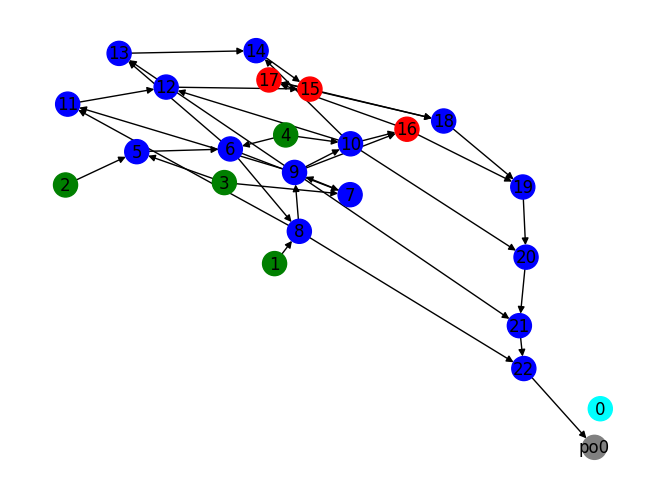

In [75]:
xag = result.artifacts['xag']
color_map = result.artifacts['color_map']
nx.draw(xag, node_color=color_map, with_labels=True)

In [ ]:
def decompose(xag: nx.MultiDiGraph, input_nodes, level: int = 1):
    from copy import deepcopy
    from collections import deque

    """
    Recursively decompose graph and dynamically choose optimal subgraphs
    """

    # Base Case: level 3
    if level >= 3:
        return xag

    # strategy: Loop over each input variable and do Shannon expansion to create 2 graphs (DPLL)
    for input in input_nodes: 
        g1 = deepcopy(xag) # assume input is true

        queue = deque()
        queue.append((input, sympy.true))

        # explore children of input node
        for _, v, data in g1.out_edges(input, data=True):
            # check edge for negation and queue the propogating signal 
            outgoing_signal = sympy.false if data['negated'] else sympy.true
            
            # queue nodes with a new incoming constant signal
            queue.append((v, outgoing_signal))

        g1.remove_node(input)

        while not queue:
            node, insignal = queue.popleft()
            node_label = g1.nodes[node].get('label', 'po0')

            in_edge

            # given changed incoming signal, check for outgoing changes
            if node_label == "XOR":




decompose(xag, ["1"])


# Benchmarking Expressions for Cliques

In [28]:
import sympy.logic.boolalg as boolalg

for sym in expr.free_symbols:
    print(expr.count(sym))

7
2
9
5


In [73]:
from collections import defaultdict

big_expr_str = "~(x5 & x6) & ~(x5 & x7) & ~(x1 ^ (x1 & ~x3 & ~x6 & ~x8)) & ~(~(x6 & ~(~(x1 & x2 & x3) & ~(x4 & (x3 ^ ((x1 ^ x3) & (x2 ^ x3)))) & ~(x5 & ~(~(x3 ^ ((x1 ^ x3) & (x2 ^ x3))) & ~(x4 & ~(~x1 & ~x2 & ~x3)))))) & ~((x1 & x2 & x3) ^ ((x5 ^ (x1 & x2 & x3)) & ~(x4 ^ (~(x4 ^ (x4 & (x3 ^ ((x1 ^ x3) & (x2 ^ x3))))) & ~(x4 ^ (x1 & x2 & x3) ^ (x4 & (x3 ^ ((x1 ^ x3) & (x2 ^ x3))))))))) & ~(x7 & ~(~(x1 & x2 & x3) & ~(x4 & (x3 ^ ((x1 ^ x3) & (x2 ^ x3)))) & ~(x5 & ~(~(x3 ^ ((x1 ^ x3) & (x2 ^ x3))) & ~(x4 & ~(~x1 & ~x2 & ~x3)))) & ~(x6 & ~(~(x3 ^ ((x1 ^ x3) & (x2 ^ x3))) & ~(x4 & ~(~x1 & ~x2 & ~x3)) & ~(x5 & ~(~x1 & ~x2 & ~x3 & ~x4)))))) & ~(x8 & ~(~(x1 & x2 & x3) & ~(x4 & (x3 ^ ((x1 ^ x3) & (x2 ^ x3)))) & ~(x5 & ~(~(x3 ^ ((x1 ^ x3) & (x2 ^ x3))) & ~(x4 & ~(~x1 & ~x2 & ~x3)))) & ~(x6 & ~(~(x3 ^ ((x1 ^ x3) & (x2 ^ x3))) & ~(x4 & ~(~x1 & ~x2 & ~x3)) & ~(x5 & ~(~x1 & ~x2 & ~x3 & ~x4)))) & ~(x7 & ~(~(x3 ^ ((x1 ^ x3) & (x2 ^ x3))) & ~(x4 & ~(~x1 & ~x2 & ~x3)) & ~(x6 ^ ((x5 ^ x6) & ~(x6 ^ (~x1 & ~x2 & ~x3 & ~x4)))))))))" 


sympy_big_expr = sympy.parse_expr(big_expr_str)

#4 defaultdict(<class 'int'>, {1: 4}) {'x7': 3, 'x2': 26, 'x5': 9, 'x1': 28, 'x3': 49, 'x6': 8, 'x8': 2, 'x4': 17}

true_counts = 0
for t, v in boolalg.truth_table(sympy_big_expr, symbols("x1 x3 x4")):
    counts = defaultdict(int)
    for sym in v.free_symbols:
        counts[sym] += v.count(sym)
    print(v.args)
    print(counts)
    


print(f"{true_counts}/{2**8} ({true_counts / 2 **8:.02f}%)inputs")


(~(x5 & x6), ~(x5 & x7), ~(~(x2 & x5 & x6 & x7) & ~(x8 & ~(~(x2 & x5 & x6) & ~(x7 & (x6 ^ ((x5 ^ x6) & ~(x6 ^ ~x2))))))))
defaultdict(<class 'int'>, {x5: 5, x7: 3, x2: 3, x8: 1, x6: 6})
(~(x5 & x6), ~(x5 & x7), ~(~(x2 & x5 & x6) & ~(x7 & ~(~(x2 & x5) & ~(x6 & ~(~x2 & ~x5)))) & ~(x8 & ~(~(x2 & x5) & ~(x6 & ~(~x2 & ~x5)) & ~(x7 & ~(~x2 & ~(x6 ^ (~x6 & (x5 ^ x6)))))))))
defaultdict(<class 'int'>, {x5: 8, x7: 3, x2: 6, x8: 1, x6: 7})
(~(x5 & x6), ~(x5 & x7), ~(~(x2 & x5 & x6) & ~(x7 & ~(~(x2 & x5) & ~(x6 & ~(~x2 & ~x5)))) & ~(x8 & ~(~(x2 & x5) & ~(x6 & ~(~x2 & ~x5)) & ~(x7 & ~(~x2 & ~(x6 ^ (~x6 & (x5 ^ x6)))))))))
defaultdict(<class 'int'>, {x5: 8, x7: 3, x2: 6, x8: 1, x6: 7})
(~(x5 & x6), ~(x5 & x7), ~(~(x2 & x5) & ~(x6 & ~(~x2 & ~x5)) & ~(x7 & ~(~x2 & ~x5 & ~x6)) & ~(x8 & ~(~x2 & ~x5 & ~x6 & ~x7))))
defaultdict(<class 'int'>, {x5: 6, x7: 3, x2: 4, x8: 1, x6: 4})
(~x6, ~x8, ~(x5 & x6), ~(x5 & x7), ~(~(x2 & x5 & x6) & ~(x7 & ~(~(x2 & x5) & ~(x6 & ~(~x2 & ~x5)))) & ~(x8 & ~(~(x2 & x5) & ~(x

In [ ]:
exp1 = sympy.parse_expr("a ^ (a & b)")
exp2 = sympy.parse_expr("a & ~b")

syms = symbols("a b c")
equal = True
for (t1, v1), (t2, v2) in zip(boolalg.truth_table(exp1, syms), boolalg.truth_table(exp2, syms)):
    print (v1, v2)

    if v1 != v2:
        equal = False

if equal == False:
    print("NOT Equivalent")
else: 
    print("Equivalent!")

False False
False False
False True
False True
True False
True False
False False
False False
NOT Equivalent


In [91]:
sympy.Not(sympy.true)

False